<a href="https://colab.research.google.com/github/ChrisChukwunyereNwaiwu/Supply-Chain-Project/blob/main/Retail_Sales_Forecast_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


import libraries

In [ ]:

import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import ipywidgets as widgets
import plotly.offline as py
import xgboost as xgb
import matplotlib.pyplot as mpp
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import plotly.io as pio
import statsmodels.api as sm
import seaborn as sb
import math
from sklearn.metrics import mean_squared_error
pio.templates
from IPython.display import display
from matplotlib import pyplot as plt
from plotly.figure_factory import create_table
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA



DATA  PRE-PROCESSING

Import Dataset

In [ ]:
df = pd.read_csv('mock_kaggle.csv')

check the headings

In [ ]:
df.shape

(937, 4)

check Basic Info of the df

In [ ]:
df.info

<bound method DataFrame.info of            data  venda  estoque  preco
0    2014-01-01      0     4972   1.29
1    2014-01-02     70     4902   1.29
2    2014-01-03     59     4843   1.29
3    2014-01-04     93     4750   1.29
4    2014-01-05     96     4654   1.29
..          ...    ...      ...    ...
932  2016-07-27     98     3179   2.39
933  2016-07-28    108     3071   2.39
934  2016-07-29    128     4095   2.39
935  2016-07-30    270     3825   2.39
936  2016-07-31    183     3642   2.39

[937 rows x 4 columns]>

In [ ]:
df.head(10)

,data,venda,estoque,preco
0,2014-01-01,0,4972,1.29
1,2014-01-02,70,4902,1.29
2,2014-01-03,59,4843,1.29
3,2014-01-04,93,4750,1.29
4,2014-01-05,96,4654,1.29
5,2014-01-06,145,4509,1.29
6,2014-01-07,179,4329,1.29
7,2014-01-08,321,4104,1.29
8,2014-01-09,125,4459,1.09
9,2014-01-10,88,5043,1.09


In [ ]:
df.tail(10)

,data,venda,estoque,preco
927,2016-07-22,98,917,2.39
928,2016-07-23,133,1550,2.39
929,2016-07-24,130,1420,2.39
930,2016-07-25,62,1358,2.39
931,2016-07-26,97,2893,2.39
932,2016-07-27,98,3179,2.39
933,2016-07-28,108,3071,2.39
934,2016-07-29,128,4095,2.39
935,2016-07-30,270,3825,2.39
936,2016-07-31,183,3642,2.39


Renaming the data columns from Spanish to English

In [ ]:
df = df.rename(columns = {'data':'Date', 'venda': 'Sales', 'estoque': 'Stock', 'preco': 'Price'})


let's Transpose the data

In [ ]:
df.transpose()

,0,1,2,3,4,5,6,7,8,9,...,927,928,929,930,931,932,933,934,935,936
Date,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,...,2016-07-22,2016-07-23,2016-07-24,2016-07-25,2016-07-26,2016-07-27,2016-07-28,2016-07-29,2016-07-30,2016-07-31
Sales,0,70,59,93,96,145,179,321,125,88,...,98,133,130,62,97,98,108,128,270,183
Stock,4972,4902,4843,4750,4654,4509,4329,4104,4459,5043,...,917,1550,1420,1358,2893,3179,3071,4095,3825,3642
Price,1.29,1.29,1.29,1.29,1.29,1.29,1.29,1.29,1.09,1.09,...,2.39,2.39,2.39,2.39,2.39,2.39,2.39,2.39,2.39,2.39


In [ ]:
# Print column names to verify existence of 'Date' column
print(df.columns)

Index(['Date', 'Sales', 'Stock', 'Price'], dtype='object')


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df.to_csv('Mock.csv', index=False)

check for missing values

In [ ]:
missing_values = df.isnull().sum()
print(missing_values)

Date     0
Sales    0
Stock    0
Price    0
dtype: int64


Performing Exploratory Data Analysis (EDA) on the Dataset

Text(0, 0.5, 'Frequency')

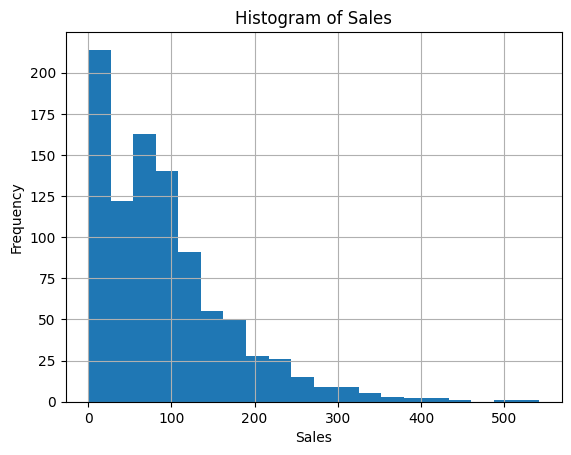

In [ ]:
df['Sales'].hist(bins=20)
plt.title('Histogram of Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')
#plt.show()


<Axes: >

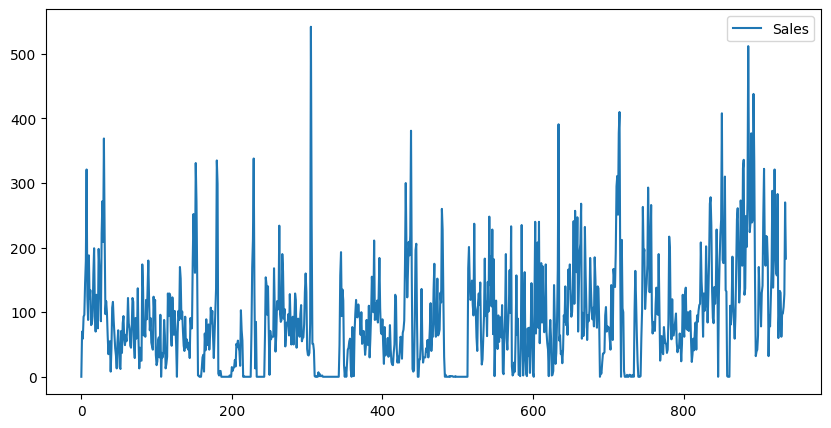

In [ ]:
#visualisation of the sales

df['Sales'].plot(figsize = (10,5), legend = True)

Visualize the price

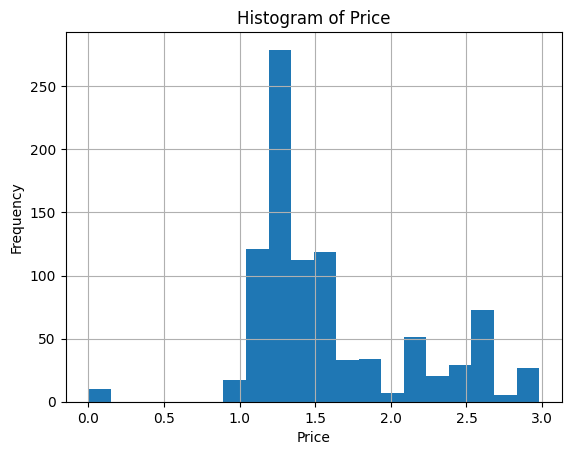

In [ ]:
df['Price'].hist(bins=20)
plt.title('Histogram of Price')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

visualize a 100 day sales using line plot

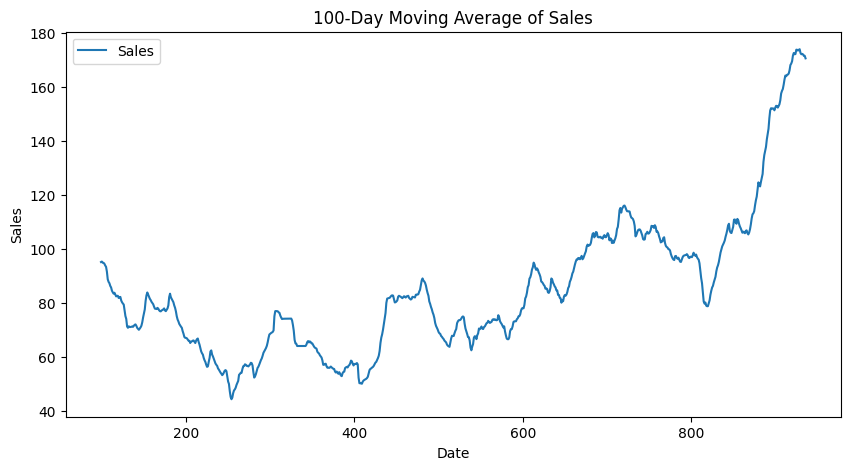

In [ ]:
df['Sales'].rolling(window=100).mean().plot(figsize = (10,5), legend = True)
plt.title('100-Day Moving Average of Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

Creating a scatterplot of the Price and sales

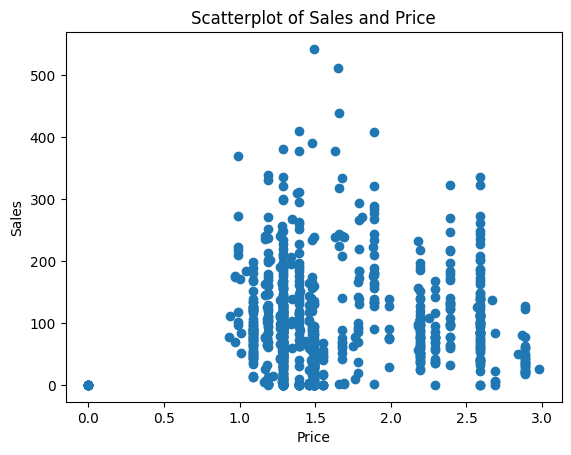

In [ ]:
plt.scatter(df['Price'], df['Sales'])
plt.title('Scatterplot of Sales and Price')
plt.xlabel('Price')
plt.ylabel('Sales')
plt.show()

Building and Testing Different Models


In [ ]:
# load the dataset
data = pd.read_csv('Mock.csv')

# select the features and the target variable
X = data.drop(columns=['Date'])
y = data['Sales']

In [ ]:
# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# scale the numeric columns in X_train and X_test
numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])


In [ ]:
# train a linear regression model on the training set
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [ ]:
# evaluate the model on the test set
y_pred = regressor.predict(X_test)
score = regressor.score(X_test, y_test)
print(f'R-squared score: {score:.2f}')


R-squared score: 1.00


In [ ]:
y_pred = regressor.predict(X_test)

In [ ]:
y_pred

array([-5.68434189e-14,  4.80000000e+01,  4.50000000e+01,  2.57000000e+02,
        7.60000000e+01,  1.24000000e+02,  1.35000000e+02,  1.19000000e+02,
        1.90000000e+01, -5.68434189e-14,  1.29000000e+02,  9.60000000e+01,
        3.00000000e+00, -5.68434189e-14,  6.20000000e+01, -5.68434189e-14,
       -5.68434189e-14,  5.12000000e+02,  1.02000000e+02,  6.40000000e+01,
        2.32000000e+02,  2.08000000e+02,  2.70000000e+02,  3.69000000e+02,
       -5.68434189e-14,  9.80000000e+01,  1.07000000e+02,  3.77000000e+02,
        5.60000000e+01,  8.80000000e+01,  2.20000000e+01,  7.80000000e+01,
        8.00000000e+00,  7.70000000e+01,  6.20000000e+01,  8.40000000e+01,
        9.30000000e+01,  9.10000000e+01,  1.61000000e+02,  4.80000000e+01,
        8.30000000e+01, -5.68434189e-14,  1.62000000e+02,  1.11000000e+02,
        2.00000000e+00,  2.30000000e+01,  8.40000000e+01,  4.10000000e+01,
        1.96000000e+02,  1.00000000e+00,  1.00000000e+00, -5.68434189e-14,
        4.80000000e+01,  

Training Different Models on the Data set


data = pd.read_csv('Mock.csv', index_col='Date')

In [ ]:
data = pd.read_csv('Mock.csv', index_col='Date')

In [ ]:
#First Approach :
#as we have seasonality (non-stationary) data needs to be converted/flattened.

data['Sales_Shift'] = data['Sales'].shift(periods = 1)

#here period is 1 as we are taking one previous value

In [ ]:
data.head()

,Sales,Stock,Price,Sales_Shift
Date,,,,
2014-01-01,0,4972,1.29,NaN
2014-01-02,70,4902,1.29,0.0
2014-01-03,59,4843,1.29,70.0
2014-01-04,93,4750,1.29,59.0
2014-01-05,96,4654,1.29,93.0


In [ ]:
#To understand seasonality in detail. Let's try Seasonal decomposition


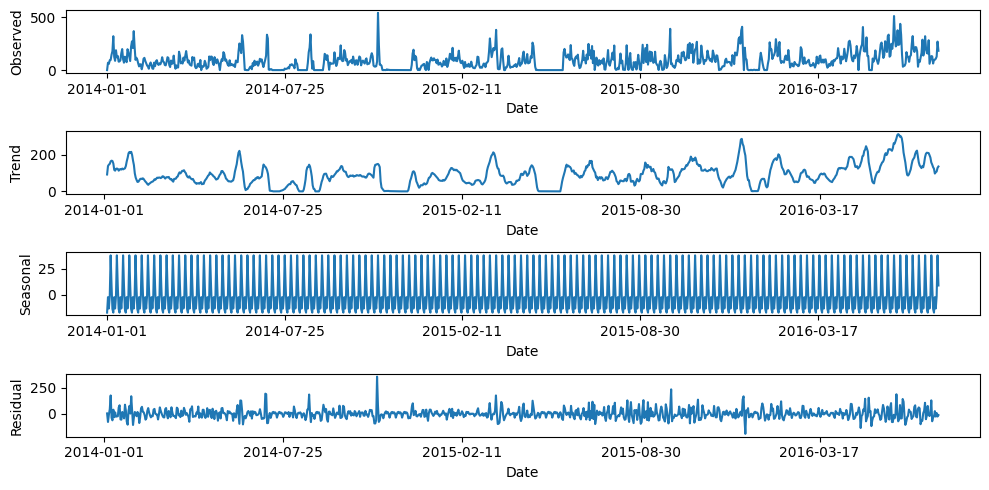

In [ ]:

sd_sales = seasonal_decompose(data['Sales'], model='additive', period=7)
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10,5))
sd_sales.observed.plot(ax=axes[0])
axes[0].set_ylabel('Observed')
sd_sales.trend.plot(ax=axes[1])
axes[1].set_ylabel('Trend')
sd_sales.seasonal.plot(ax=axes[2])
axes[2].set_ylabel('Seasonal')
sd_sales.resid.plot(ax=axes[3])
axes[3].set_ylabel('Residual')
plt.tight_layout()
plt.show()


  #there is no indicative trend or pattern

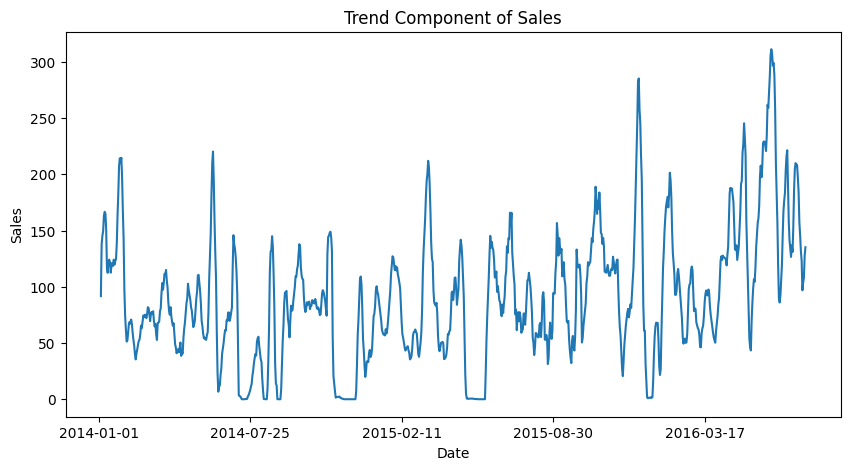

In [ ]:
sd_sales.trend.plot(figsize=(10, 5))
mpp.title('Trend Component of Sales')
mpp.xlabel('Date')
mpp.ylabel('Sales')
mpp.show()


In [ ]:
#to check correlation (if there is correlation we may have to opt for a different model)

data[['Sales', 'Stock', 'Price']].corr()

,Sales,Stock,Price
Sales,1.000000,0.153659,0.094779
Stock,0.153659,1.000000,-0.032604
Price,0.094779,-0.032604,1.000000


 we have seasonality (non-stationary) data needs to be converted.

In [ ]:

data['Sales_Shift'] = data['Sales'].shift(periods = 1)


In [ ]:
data.head()

,Sales,Stock,Price,Sales_Shift
Date,,,,
2014-01-01,0,4972,1.29,NaN
2014-01-02,70,4902,1.29,0.0
2014-01-03,59,4843,1.29,70.0
2014-01-04,93,4750,1.29,59.0
2014-01-05,96,4654,1.29,93.0


The first value in diff is NaN, exlude this while building models or finding correlations

In [ ]:
data = data[1:]

In [ ]:
data.head()

,Sales,Stock,Price,Sales_Shift
Date,,,,
2014-01-02,70,4902,1.29,0.0
2014-01-03,59,4843,1.29,70.0
2014-01-04,93,4750,1.29,59.0
2014-01-05,96,4654,1.29,93.0
2014-01-06,145,4509,1.29,96.0




"Diff" is now the target/dependent variable

Differencing method (subtract Sales from Sales_shift)

In [ ]:

data['diff'] = data['Sales']-data['Sales_Shift']

The Data is stationery

<Axes: xlabel='Date'>

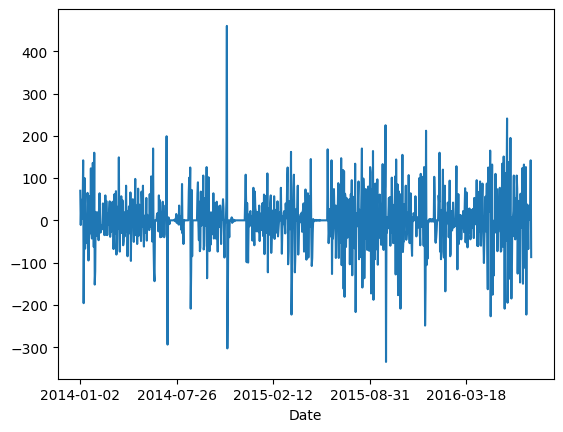

In [ ]:
data['diff'].plot()



Splitting the dataset into the Training set and Test set

In [ ]:

size = int(len(data)*0.70)
train_data = data[:size]
train_data.tail()

,Sales,Stock,Price,Sales_Shift,diff
Date,,,,,
2015-10-20,93,1198,1.78,120.0,-27.0
2015-10-21,100,1096,1.78,93.0,7.0
2015-10-22,137,1055,1.27,100.0,37.0
2015-10-23,241,1006,1.27,137.0,104.0
2015-10-24,113,893,1.27,241.0,-128.0


In [ ]:
test_data = data[size:]
test_data.head()

,Sales,Stock,Price,Sales_Shift,diff
Date,,,,,
2015-10-25,257,636,1.28,113.0,144.0
2015-10-26,166,474,1.28,257.0,-91.0
2015-10-27,162,312,1.28,166.0,-4.0
2015-10-28,247,1121,1.28,162.0,85.0
2015-10-29,70,1435,1.78,247.0,-177.0


In [ ]:
#ARMA model
arma_model = ARIMA(train_data['diff'], order = (1, 0, 1))
arma_model_results = arma_model.fit()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [ ]:
arma_model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   diff   No. Observations:                  655
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -3581.809
Date:                Sun, 02 Jul 2023   AIC                           7171.618
Time:                        19:06:19   BIC                           7189.556
Sample:                             0   HQIC                          7178.573
                                - 655                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.042      0.048      0.962      -0.081       0.085
ar.L1          0.5787      0.027     21.392      0.000       0.526       0.632
ma.L1         -0.9966      0.010   -100.311      0.000      -1.016      -0.977
sigma2      3274.2356     98.172     33.352      0.000    3081.821    3466.650
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              2205.15
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               1.62   Skew:                             1.65
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:

# create and fit MA model
ma_model = SARIMAX(train_data['Sales'], order=(1, 0, 1))
ma_model_results = ma_model.fit()

# print summary of results
print(ma_model_results.summary())


                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  655
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -3612.872
Date:                Sun, 02 Jul 2023   AIC                           7231.745
Time:                        19:06:19   BIC                           7245.199
Sample:                             0   HQIC                          7236.961
                                - 655                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9020      0.017     54.475      0.000       0.870       0.935
ma.L1         -0.3034      0.036     -8.387      0.000      -0.374      -0.233
sigma2      3612.1429     89.342     40.430      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



 predicting the test data for AR

In [ ]:

# define and fit AR model
ar_model = ARIMA(train_data['diff'], order=(1, 0, 0))
ar_model_results = ar_model.fit()

# Predicting the test data using AR model
start = len(train_data['diff'])
end = len(train_data['diff'])+len(test_data['diff'])-1

Prediction1 = ar_model_results.predict(start=start, end=end)

Prediction1.index = data.index[start:end+1]

print(Prediction1)



Date
2015-10-25    28.002687
2015-10-26    -5.870247
2015-10-27     1.484599
2015-10-28    -0.112362
2015-10-29     0.234386
                ...    
2016-07-27     0.172528
2016-07-28     0.172528
2016-07-29     0.172528
2016-07-30     0.172528
2016-07-31     0.172528
Name: predicted_mean, Length: 281, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Visualize the Prediction

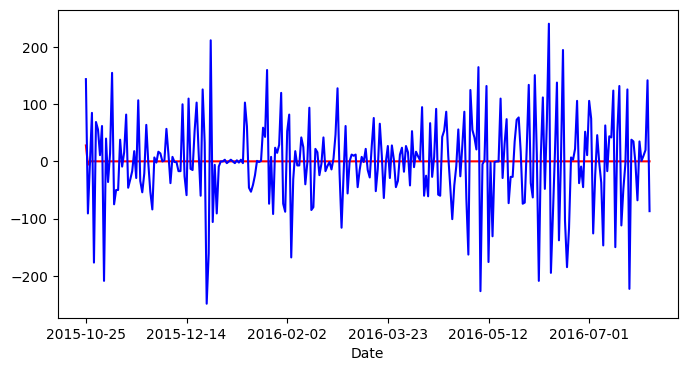

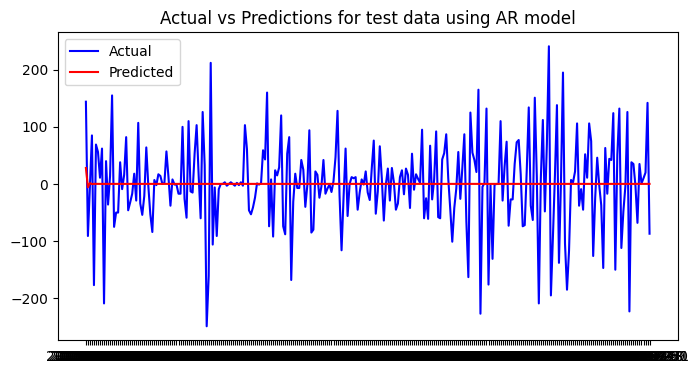

In [ ]:

Prediction1.plot(figsize = (8, 4), color = 'red')
test_data['diff'].plot(figsize = (8, 4), color = 'blue')

# create a new figure
fig = plt.figure(figsize=(8, 4))

# add a title
plt.title('Actual vs Predictions for test data using AR model')

# plot the actual values in blue
plt.plot(test_data['diff'], color='blue', label='Actual')

# plot the predicted values in red
plt.plot(Prediction1, color='red', label='Predicted')

# add a legend
plt.legend()

# show the plot
plt.show()

In [ ]:
rmse1 = math.sqrt(mean_squared_error(test_data['diff'], Prediction1))
rmse1

75.14238928026857

 predicting the test data for MA

In [ ]:


# define and fit MA model
ma_model = ARIMA(train_data['diff'], order=(0, 0, 1))
ma_model_results = ma_model.fit()

# Predicting the test data using MA model
start = len(train_data['diff'])
end = len(train_data['diff'])+len(test_data['diff'])-1

Prediction2 = ma_model_results.predict(start=start, end=end)

Prediction2.index = data.index[start:end+1]

print(Prediction2)




/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Date
2015-10-25    34.152011
2015-10-26     0.171472
2015-10-27     0.171472
2015-10-28     0.171472
2015-10-29     0.171472
                ...    
2016-07-27     0.171472
2016-07-28     0.171472
2016-07-29     0.171472
2016-07-30     0.171472
2016-07-31     0.171472
Name: predicted_mean, Length: 281, dtype: float64


Visualizing the prediction

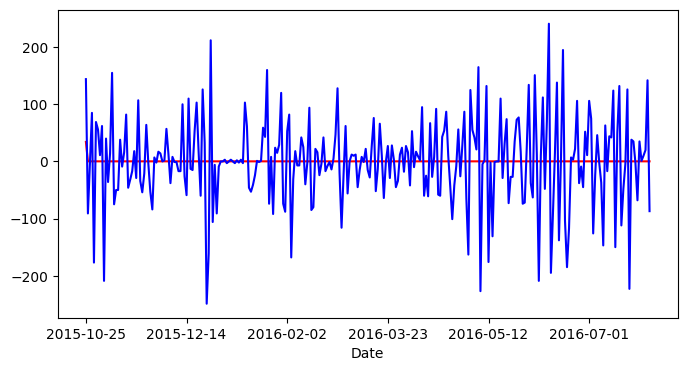

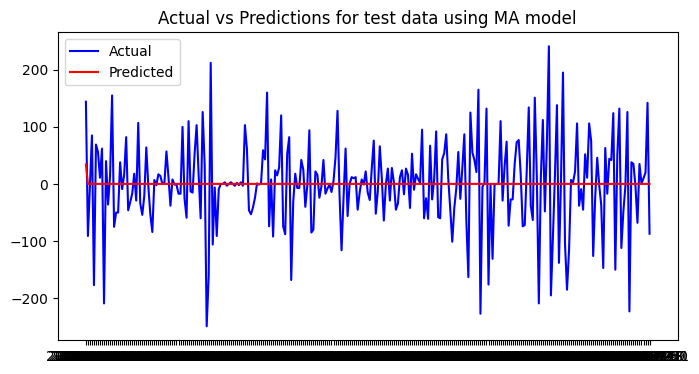

In [ ]:
Prediction2.plot(figsize = (8, 4), color = 'red')
test_data['diff'].plot(figsize = (8, 4), color = 'blue')

# create a new figure
fig = plt.figure(figsize=(8, 4))

# add a title
plt.title('Actual vs Predictions for test data using MA model')

# plot the actual values in blue
plt.plot(test_data['diff'], color='blue', label='Actual')

# plot the predicted values in red
plt.plot(Prediction2, color='red', label='Predicted')

# add a legend
plt.legend()

# show the plot
plt.show()

In [ ]:
rmse2 = math.sqrt(mean_squared_error(test_data['diff'], Prediction2))
rmse2

75.13272221424087

In [ ]:

# Define and fit ARMA model
arma_model = ARIMA(train_data['diff'], order=(1, 0, 1))
arma_model_results = arma_model.fit()

# Predicting the test data using ARMA model
start = len(train_data['diff'])
end = len(train_data['diff']) + len(test_data['diff']) - 1

Prediction3 = arma_model_results.predict(start=start, end=end)

Prediction3.index = data.index[start:end+1]

print(Prediction3)




/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Date
2015-10-25   -14.892018
2015-10-26    -8.616492
2015-10-27    -4.985125
2015-10-28    -2.883815
2015-10-29    -1.667880
                ...    
2016-07-27     0.002030
2016-07-28     0.002030
2016-07-29     0.002030
2016-07-30     0.002030
2016-07-31     0.002030
Name: predicted_mean, Length: 281, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



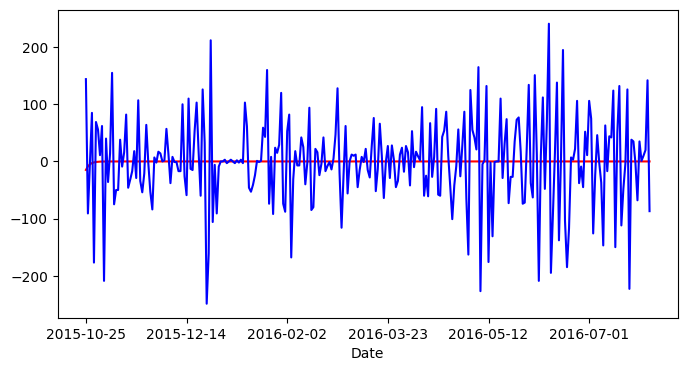

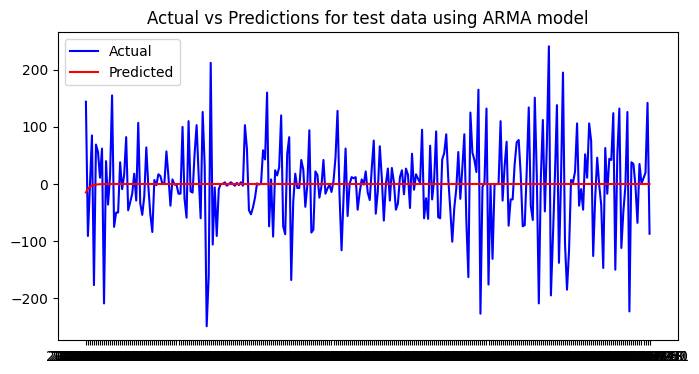

In [ ]:
Prediction3.plot(figsize=(8, 4), color='red')
test_data['diff'].plot(figsize=(8, 4), color='blue')

# Create a new figure
fig = plt.figure(figsize=(8, 4))

# Add a title
plt.title('Actual vs Predictions for test data using ARMA model')

# Plot the actual values in blue
plt.plot(test_data['diff'], color='blue', label='Actual')

# Plot the predicted values in red
plt.plot(Prediction3, color='red', label='Predicted')

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
rmse3 = math.sqrt(mean_squared_error(test_data['diff'], Prediction2))
rmse3

75.13272221424087

In [ ]:
data.head()

,Sales,Stock,Price,Sales_Shift,diff
Date,,,,,
2014-01-02,70,4902,1.29,0.0,70.0
2014-01-03,59,4843,1.29,70.0,-11.0
2014-01-04,93,4750,1.29,59.0,34.0
2014-01-05,96,4654,1.29,93.0,3.0
2014-01-06,145,4509,1.29,96.0,49.0


Train the XGBOOST model for better perfomance

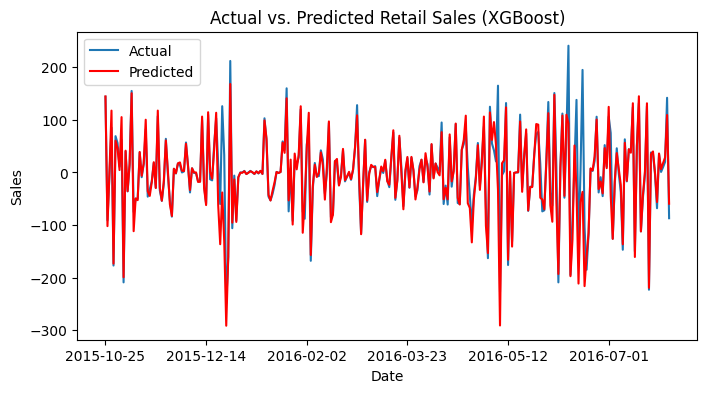

In [ ]:


# Split the data into train and test sets

x_train = train_data[['Sales', 'Stock', 'Price', 'Sales_Shift', 'diff']]
y_train = train_data['Sales']

x_test = test_data[['Sales', 'Stock', 'Price', 'Sales_Shift', 'diff']]
y_test = test_data['Sales']



# Define the features and target variable
X_train = train_data.drop(columns=['diff'])
y_train = train_data['diff']

X_test = test_data.drop(columns=['diff'])
y_test = test_data['diff']

# Define and fit the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
xgb_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = xgb_model.predict(X_test)

# Convert the predictions to a Pandas series with the correct index
predictions4 = pd.Series(y_pred, index=y_test.index)

# Plot the actual and predicted values
ax = test_data['diff'].plot(label='Actual', figsize=(8, 4))
predictions4.plot(ax=ax, label='Predicted', color='red')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_title('Actual vs. Predicted Retail Sales (XGBoost)')
ax.legend()


In [ ]:
y_pred

array([ 1.44587555e+02, -1.02052399e+02,  2.56036997e+00,  1.17613716e+02,
       -1.73359726e+02,  6.03511848e+01,  4.63248634e+01,  4.58566046e+00,
        1.05242760e+02, -1.99230530e+02,  4.14091072e+01, -3.54540634e+01,
        1.66892796e+01,  1.50657623e+02, -1.11682434e+02, -4.93854904e+01,
       -5.26377602e+01,  3.89794006e+01, -6.29103374e+00,  1.71951294e+01,
        1.00284843e+02, -3.56278458e+01, -4.46209335e+01, -1.88437309e+01,
        1.95113354e+01, -2.95585003e+01,  1.17664841e+02, -2.89065018e+01,
       -5.36762848e+01, -1.57668562e+01,  6.08242455e+01,  3.81569767e+00,
       -6.04126472e+01, -8.27326584e+01,  7.08248615e+00, -1.34083951e+00,
        1.72811356e+01,  1.91454449e+01,  3.40459490e+00,  2.72918367e+00,
        5.45453453e+01,  1.33839378e+01, -3.34032021e+01,  7.98082972e+00,
        5.69974110e-02,  1.40152760e-02, -1.79610252e+01, -1.76738720e+01,
        1.06258041e+02, -2.94756298e+01, -6.20171623e+01,  1.14556580e+02,
        1.17553020e+00, -

In [ ]:
feature_imp = pd.DataFrame(data=xgb_model.feature_importances_,
                           index=xgb_model.feature_names_in_,
                          columns=['importance_score'])


In [ ]:
print(feature_imp)

             importance_score
Sales                0.366507
Stock                0.001908
Price                0.001770
Sales_Shift          0.629815


In [ ]:
# Calculate the RMSE
rmse4 = math.sqrt(mean_squared_error(test_data['diff'], predictions4))
print(rmse4)

32.879502914473846


Train the RandomForest model for better perfomance

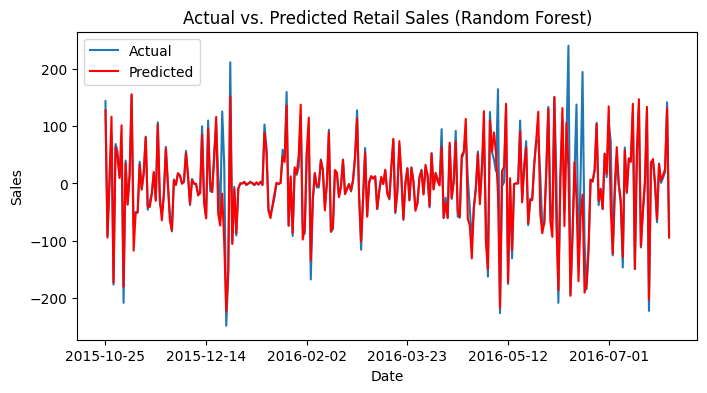

In [ ]:


# Define the features and target variable
X_train = train_data.drop(columns=['diff'])
y_train = train_data['diff']

X_test = test_data.drop(columns=['diff'])
y_test = test_data['diff']

# Define and fit the random forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_model.predict(X_test)

# Convert the predictions to a Pandas series with the correct index
predictions5 = pd.Series(y_pred, index=y_test.index)

# Plot the actual and predicted values
ax = test_data['diff'].plot(label='Actual', figsize=(8, 4))
predictions5.plot(ax=ax, label='Predicted', color='red')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_title('Actual vs. Predicted Retail Sales (Random Forest)')
ax.legend()


In [ ]:
# Calculate the root mean squared error (RMSE)
rmse5 = np.sqrt(mean_squared_error(y_test, y_pred))
print(rmse5)

31.702761451171618


Let's Display the DATA Science Product

Output()

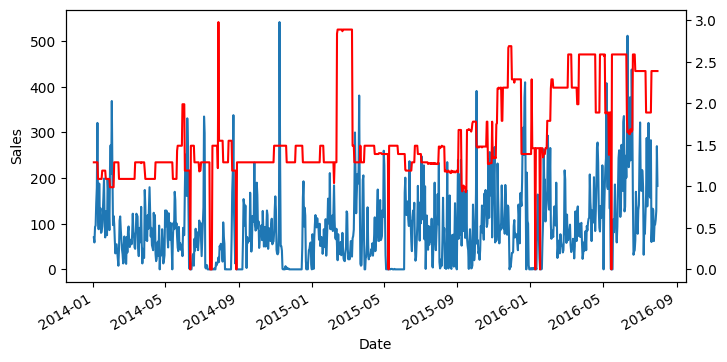

In [ ]:

# Creating Graphical User Interface (GUI) elements
RSFT_dropdown = widgets.Dropdown(options=list(df.columns)[1:], value='Sales', description='RSFT:')
price_checkbox = widgets.Checkbox(value=True, description='Price')
sales_diff_checkbox = widgets.Checkbox(value=False, description='Sales Diff')
date_dropdown = widgets.Dropdown(options=['Day', 'Week', 'Month'], value='Day', description='Date:')
output_plot = widgets.Output()

# Defining function to create plot
def create_plot(RSFT,  price, sales_diff, diff):
    data = df.copy()

    # Calculate sales difference
    if sales_diff:
        data['Sales Diff'] = data[RSFT].diff()
        data = data.dropna()

    # Calculate price difference
    if price:
        data['Price Diff'] = data['Price'].diff()
        data = data.dropna()

    if diff == 'Day':
        data = data.set_index('Date')
    elif diff == 'Week':
        data = data.set_index('Date').resample('W').mean()
    else:
        data = data.set_index('Date').resample('M').mean()

    # Plot the data
    fig, ax = plt.subplots(figsize=(8, 4))
    data[RSFT].plot(ax=ax)
    ax.set_xlabel('Date')
    ax.set_ylabel(RSFT)
    if price:
        ax.twinx().plot(data['Price'], 'r')
    if sales_diff:
        ax.twinx().plot(data['Sales Diff'], 'g')
    plt.show()

# Defining function to handle changes in GUI elements
def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        with output_plot:
            output_plot.clear_output(wait=True)
            create_plot(RSFT_dropdown.value, price_checkbox.value, sales_diff_checkbox.value, date_dropdown.value)

# Display GUI elements
RSFT_box = widgets.HBox([RSFT_dropdown, price_checkbox, sales_diff_checkbox, date_dropdown])
display(RSFT_box, output_plot)

# Call create_plot function to create initial plot
create_plot(RSFT_dropdown.value, price_checkbox.value, sales_diff_checkbox.value, date_dropdown.value)

# Add on_change handler to GUI elements
RSFT_dropdown.observe(on_change)
price_checkbox.observe(on_change)
sales_diff_checkbox.observe(on_change)
date_dropdown.observe(on_change)
